In [155]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from datetime import datetime
from functools import reduce
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [17]:
data_directory = '../data/'
file_names = [
    'Batch_corrected_Expression_Public_24Q4_subsetted.csv',
    'Damaging_Mutations_subsetted.csv', 
    'Harmonized_RPPA_CCLE_subsetted.csv',
    'Hotspot_Mutations_subsetted.csv', 
    'IC50_AUC_merged.csv', 
    'Metabolomics_subsetted.csv',
    'miRNA_Expression_subsetted.csv',
    'Omics_Absolute_CN_Gene_Public_24Q4_subsetted.csv'
    ]
model_type = "Linear_Regression"

# Data Load

In [18]:
smiles = pd.read_csv("../data/drugID_name_pubchem_smiles.csv")

In [19]:
# load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenize
tokens = tokenizer(smiles["smiles"].tolist(), padding=True, truncation=True, return_tensors="pt")

# embedded tokenized SMILES
with torch.no_grad():
    outputs = model(**tokens)

# CLS token (for now, we will only use CLS token)
cls_embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, hidden_dim)

cls_embeddings_np = cls_embeddings.cpu().numpy()

smiles["CLS"] = list(cls_embeddings_np)

print(smiles.head())

   drugID          drugName  pubchemID  \
0    1003  (+)-CAMPTOTHECIN      24360   
1    1004            VELBAN    5388983   
2    1006        CYTARABINE       6253   
3    1007         DOCETAXEL     148124   
4    1010         GEFITINIB     123631   

                                              smiles  \
0  CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...   
1  CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...   
2                 C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O   
3  CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...   
4  COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...   

                                                 CLS  
0  [-0.050625782, 0.8847862, -1.6744756, 1.318763...  
1  [1.5243864, 0.27689624, -0.80197245, -0.993637...  
2  [-0.3921864, 0.06059088, -0.8843427, 0.2352088...  
3  [0.51168895, 0.7362516, -1.3978798, -0.6953381...  
4  [-0.7337884, 0.7460441, -1.1952801, 1.1188803,...  


In [20]:
IC50_AUC = pd.read_csv("../data/IC50_AUC_merged.csv")
IC50_AUC = IC50_AUC.rename(columns={"Unnamed: 0": "CellLineID"})

In [21]:
melted = IC50_AUC.melt(
    id_vars=["CellLineID"],  # fixed column
    var_name="metric_drug",  # column names that will be one single column
    value_name="value"       
)
melted.head()

,CellLineID,metric_drug,value
0,ACH-000001,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,NaN
1,ACH-000002,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-6.358658
2,ACH-000004,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-6.277264
3,ACH-000006,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-5.994797
4,ACH-000007,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,NaN


In [22]:
# ex: "Drug sensitivity AUC (Sanger GDSC2) CAMPTOTHECIN (GDSC2:1003)" -> (AUC), (CAMPTOTHECIN), (1003)
pattern = r"(AUC|IC50).*?\((Sanger GDSC2)\)\s+(.*?)\s+\(GDSC2:(\d+)\)"

# (AUC|IC50) -> 1) AUC or IC50
# (.*?)      -> 3) Drug name (minimum match)
# (\d+)      -> 4) drug number from GDSC2:XXXX

In [23]:
melted[["Metric", "_sanger", "DrugName", "DrugNumber"]] = melted["metric_drug"].str.extract(pattern)
new_melted = melted[['CellLineID', 'value', 'Metric','DrugNumber']]
new_melted.head()

,CellLineID,value,Metric,DrugNumber
0,ACH-000001,NaN,IC50,1003
1,ACH-000002,-6.358658,IC50,1003
2,ACH-000004,-6.277264,IC50,1003
3,ACH-000006,-5.994797,IC50,1003
4,ACH-000007,NaN,IC50,1003


In [24]:
final_IC50_AUC = (
    new_melted
    .pivot(index=["CellLineID", "DrugNumber"], 
           columns="Metric", 
           values="value")
    #.reset_index()
)

In [25]:
final_IC50_AUC = final_IC50_AUC.dropna(subset=['AUC', 'IC50'], how='all') # drop the row that AUC and IC50 are both NAN
final_IC50_AUC.columns.name = None
final_IC50_AUC

AUC     IC50
CellLineID DrugNumber                   
ACH-000001 1003        0.967187      NaN
           1004        0.666062      NaN
           1005        0.977907      NaN
           1007        0.922989      NaN
           1010        0.957586      NaN
...                         ...      ...
ACH-002317 2096        0.946713      NaN
           2107        0.926422      NaN
           2109        0.916274  3.25832
           2110        0.906540      NaN
           2170        0.996681      NaN

[98430 rows x 2 columns]

In [26]:
final_IC50_AUC.to_csv("temp.csv") # had to save and reload to make CellLIneID and DrugNumber to column

In [27]:
IC50_AUC_final = pd.read_csv("temp.csv")

In [28]:
# merge IC50, AUC, and SMILES (CLS)
df_merged = pd.merge(IC50_AUC_final, smiles, left_on='DrugNumber', right_on='drugID', how='inner')

In [29]:
IC50_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'IC50']].copy()
IC50_data['AUC'] = None # each row will have either AUC or IC50 value. 
ic50_data = ic50_data.rename(columns={'IC50': 'IC50'})

auc_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'AUC']].copy()
auc_data['IC50'] = None 
auc_data = auc_data.rename(columns={'AUC': 'AUC'})

final_df = pd.concat([ic50_data, auc_data])
final_df = final_df.sort_values(by=['CellLineID', 'DrugNumber']).reset_index(drop=True)
final_df = final_df.dropna(subset=['AUC', 'IC50'], how='all').reset_index(drop=True)

final_df

/var/folders/rt/c2m6bx6n12j282w1_l6qv5l00000gn/T/ipykernel_1674/1315804172.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([ic50_data, auc_data])


,CellLineID,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000001,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050625782, 0.8847862, -1.6744756, 1.318763...",NaN,0.967187
1,ACH-000001,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.5243864, 0.27689624, -0.80197245, -0.993637...",NaN,0.666062
2,ACH-000001,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.73499787, 0.018371219, -0.49584207, 0.29506...",NaN,0.977907
3,ACH-000001,1007,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,"[0.51168895, 0.7362516, -1.3978798, -0.6953381...",NaN,0.922989
4,ACH-000001,1010,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...,"[-0.7337884, 0.7460441, -1.1952801, 1.1188803,...",NaN,0.957586
...,...,...,...,...,...,...
117641,ACH-002317,2107,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...,"[0.3243879, -0.20456098, -0.47426465, 0.152975...",NaN,0.926422
117642,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195233, -0.2668271, -1.0635843, -0.434819...",3.25832,NaN
117643,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195233, -0.2668271, -1.0635843, -0.434819...",NaN,0.916274
117644,ACH-002317,2110,C1CC(C1)NC2=NC=CC(=C2)C(=O)NCC(CN3CCC4=CC=CC=C...,"[-0.07692316, -0.47833252, -0.6763182, -0.5061...",NaN,0.906540


In [31]:
all_omics = []
files = file_names[:4] + file_names[5:]
for file in files: 
    omics = pd.read_csv(f'{data_directory}{file}')
    omics = omics.rename(columns={omics.columns[0]: "CellLineID"})
    all_omics.append(omics)
all_omics

[      CellLineID     NEMP2   SPDYE11      MED6    SPATA1    HMG20B    PITRM1  \
 0     ACH-000873  2.281262  0.016496  4.913394  0.592549  4.933815  5.068384   
 1     ACH-000860  2.397921 -0.007359  6.064227  0.790612  5.526024  5.495815   
 2     ACH-000439  1.961548  0.139871  4.366399  0.574739  5.879936  5.027458   
 3     ACH-000318  2.962951 -0.007359  6.028266  0.636129  4.722188  5.235858   
 4     ACH-001142  1.997125 -0.007359  4.781246  1.004993  5.559541  6.614231   
 ...          ...       ...       ...       ...       ...       ...       ...   
 1668  ACH-001843  2.425672  0.016474  5.064429  1.155729  6.132326  6.435993   
 1669  ACH-002074  2.435179  0.016474  4.795754  0.494388  5.265443  5.683454   
 1670  ACH-001164  1.893673  0.016474  4.460321  0.362453  5.729537  7.230451   
 1671  ACH-003180  2.717188  0.016474  4.991506  0.604765  5.400438  5.396326   
 1672  ACH-001979  2.882293  0.040215  4.678718  0.717236  6.455945  4.943213   
 
         TCIRG1    CDKN2B 

In [32]:
X_dimension_reduced_array = []
# PCA for batch expression and CN, variance for damaged

for i in range(len(all_omics)):
    omics = all_omics[i]
    if i == 0 or i == 6:
        X_cnv = omics.iloc[:, 1:]
        pca = PCA(n_components=500)
        X_pca = pca.fit_transform(X_cnv)

        X_pca_df = pd.DataFrame(X_pca)
        X_pca_df.insert(0, "CellLineID", omics["CellLineID"].values)

        print(X_pca_df.shape)
        X_dimension_reduced_array.append(X_pca_df)

    elif i == 1:
        omics_ = omics.drop(columns="CellLineID")
        # VarianceThreshold 설정 (0에 가까운 값이 대부분인 feature 제거)
        selector = VarianceThreshold(threshold=0.01) # 분산 0.01 이하의 feature 제거
        omics_reduced = selector.fit_transform(omics_)

        # 제거되지 않은 feature의 인덱스 가져오기
        selected_columns = omics_.columns[selector.get_support()]

        # DataFrame으로 변환 (컬럼 유지)
        X_reduced_df = pd.DataFrame(omics_reduced, columns=selected_columns)
        X_reduced_df = pd.concat([omics["CellLineID"], X_reduced_df], axis=1)

        print(X_reduced_df.shape)
        X_dimension_reduced_array.append(X_reduced_df)

    else:
        print(omics.shape)
        X_dimension_reduced_array.append(omics)





(1673, 501)
(1929, 1255)
(899, 145)
(1929, 540)
(927, 226)
(954, 735)
(1607, 501)


In [33]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='CellLineID', how='inner', suffixes=('', '_dup')), X_dimension_reduced_array + [final_df])
df_merged

,CellLineID,0,1,2,3,4,5,6,7,8,...,495_dup,496_dup,497_dup,498_dup,499_dup,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,3.118826,3.160370,-1.557885,3.212634,-6.070649,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050625782, 0.8847862, -1.6744756, 1.318763...",-4.325557,NaN
1,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,3.118826,3.160370,-1.557885,3.212634,-6.070649,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050625782, 0.8847862, -1.6744756, 1.318763...",NaN,0.866413
2,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,3.118826,3.160370,-1.557885,3.212634,-6.070649,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.5243864, 0.27689624, -0.80197245, -0.993637...",NaN,0.906722
3,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,3.118826,3.160370,-1.557885,3.212634,-6.070649,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.73499787, 0.018371219, -0.49584207, 0.29506...",NaN,0.955195
4,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,3.118826,3.160370,-1.557885,3.212634,-6.070649,1006,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O,"[-0.3921864, 0.06059088, -0.8843427, 0.2352088...",NaN,0.932728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59298,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,-3.536283,-1.145856,0.376511,0.790796,1.398435,2096,CC1=CN=C(N=C1C2=CNC(=C2)C(=O)NC(CO)C3=CC(=CC=C...,"[-0.058414888, 0.4698328, -0.74660987, -0.0175...",NaN,0.822895
59299,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,-3.536283,-1.145856,0.376511,0.790796,1.398435,2106,CN1C(=C(C=N1)Cl)C2=C(OC(=C2)C(=O)NC(CC3=CC(=C(...,"[0.20707873, 0.6954129, -1.7764983, 0.8822792,...",NaN,0.929802
59300,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,-3.536283,-1.145856,0.376511,0.790796,1.398435,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195233, -0.2668271, -1.0635843, -0.434819...",NaN,0.944861
59301,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,-3.536283,-1.145856,0.376511,0.790796,1.398435,2111,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...,"[0.059471514, -0.31746662, -1.1127878, -0.1648...",NaN,0.980634


In [34]:
# split to feature and target
X = df_merged.drop(columns=["CellLineID", "DrugNumber",	"smiles", "AUC", "IC50"])
y = df_merged[["AUC", "IC50"]]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,491_dup,492_dup,493_dup,494_dup,495_dup,496_dup,497_dup,498_dup,499_dup,CLS
0,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,2.398334,3.653308,9.849293,-1.732675,3.118826,3.16037,-1.557885,3.212634,-6.070649,"[-0.050625782, 0.8847862, -1.6744756, 1.318763..."
1,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,2.398334,3.653308,9.849293,-1.732675,3.118826,3.16037,-1.557885,3.212634,-6.070649,"[-0.050625782, 0.8847862, -1.6744756, 1.318763..."
2,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,2.398334,3.653308,9.849293,-1.732675,3.118826,3.16037,-1.557885,3.212634,-6.070649,"[1.5243864, 0.27689624, -0.80197245, -0.993637..."
3,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,2.398334,3.653308,9.849293,-1.732675,3.118826,3.16037,-1.557885,3.212634,-6.070649,"[0.73499787, 0.018371219, -0.49584207, 0.29506..."
4,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,2.398334,3.653308,9.849293,-1.732675,3.118826,3.16037,-1.557885,3.212634,-6.070649,"[-0.3921864, 0.06059088, -0.8843427, 0.2352088..."


In [35]:
y.head()

,AUC,IC50
0,NaN,-4.325557
1,0.866413,NaN
2,0.906722,NaN
3,0.955195,NaN
4,0.932728,NaN


In [50]:
cls_array = X["CLS"]
omics_array = X.drop(columns="CLS").to_numpy(dtype=np.float32)
y_array = y.to_numpy(dtype=np.float32)

# Scaling
# Omics -> Z-score normalization
scaler_omics = StandardScaler()
omics_array = scaler_omics.fit_transform(omics_array)

# AUC -> log transformation
epsilon = 1e-10  # prevent zero division
y_array[:, 0] = np.log10(np.where(y_array[:, 0] == 0, epsilon, y_array[:, 0]))
# Maybe MinMax Scaling?
#scaler_AUC = MinMaxScaler()
#y_array[:, 0] = scaler_AUC.fit_transform(y_array[:, 0].reshape(-1, 1)).flatten()

# IC50 -> MinMax Scaling
scaler_IC50 = MinMaxScaler()
y_array[:, 1] = scaler_IC50.fit_transform(y_array[:, 1].reshape(-1, 1)).flatten()

In [51]:
# train, validation, test : 80, 10, 10
train_smiles, test_smiles, train_omics, test_omics, train_y, test_y = train_test_split(
    cls_array, omics_array, y_array, test_size=0.1, random_state=42
)

print("train_smiles shape =", train_smiles.shape)
print("test_smiles shape =", test_smiles.shape)
print("train_omics shape =", train_omics.shape)
print("test_omics shape =", test_omics.shape)
print("train_y shape =", train_y.shape)
print("test_y shape =", test_y.shape)

train_smiles shape = (53372,)
test_smiles shape = (5931,)
train_omics shape = (53372, 3896)
test_omics shape = (5931, 3896)
train_y shape = (53372, 2)
test_y shape = (5931, 2)


# Model

First, we need to split the y data so we can fit two separate KNN models for IC50 and AUC

In [126]:
train_y_AUC = train_y[:, 0]
train_y_IC50 = train_y[:, 1]
test_y_AUC = test_y[:, 0]
test_y_IC50 = test_y[:, 1]

In [127]:
ic50_mask = ~np.isnan(train_y_IC50)
auc_mask = ~np.isnan(train_y_AUC)

train_y_IC50 = train_y_IC50[ic50_mask]
train_y_AUC = train_y_AUC[auc_mask]

train_smiles_array = np.vstack(train_smiles.values).astype('float32') 
train_x = np.hstack((train_smiles_array, train_omics))
train_x_IC50 = train_x[ic50_mask]
train_x_AUC = train_x[auc_mask]

In [130]:
# Hyperparams
neighbors = 10
weight_metric = 'uniform' # can be set to 'distance'
batch_size = 64
num_epochs = 100

In [131]:
model_AUC = KNeighborsRegressor(n_neighbors=neighbors, weights=weight_metric)
model_IC50 = KNeighborsRegressor(n_neighbors=neighbors, weights=weight_metric)

In [132]:
# DO NOT FACTOR NAN - IGNORE THEM IN EMBEDDING

model_AUC.fit(train_x_AUC, train_y_AUC)
model_IC50.fit(train_x_IC50, train_y_IC50)

KNeighborsRegressor(n_neighbors=10)

In [133]:
test_ic50_mask = ~np.isnan(test_y_IC50)
test_auc_mask = ~np.isnan(test_y_AUC)

test_y_IC50 = test_y_IC50[test_ic50_mask]
test_y_AUC = test_y_AUC[test_auc_mask]

test_smiles_array = np.vstack(test_smiles.values).astype('float32') 
test_x = np.hstack((test_smiles_array, test_omics))
test_x_IC50 = test_x[test_ic50_mask]
test_x_AUC = test_x[test_auc_mask]

In [134]:
y_pred_AUC = model_AUC.predict(test_x_AUC)
y_pred_IC50 = model_IC50.predict(test_x_IC50)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [150]:
y_pred_IC50.shape

(1079,)


 **Test Results:**
IC50_MSE: 0.0334
IC50_MAE: 0.1457
IC50_R2: 0.0705
AUC_MSE: 0.0092
AUC_MAE: 0.0487
AUC_R2: -0.0097


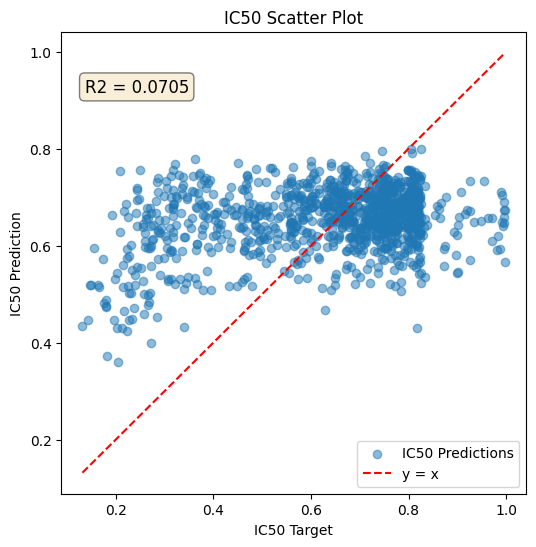

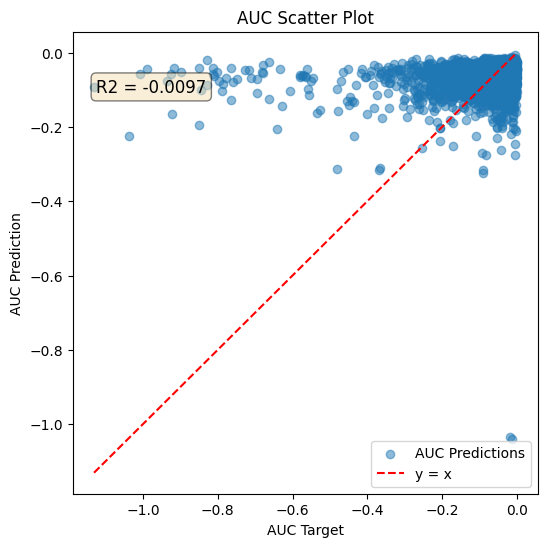

In [156]:
# evaluation
metrics = {}
if len(y_pred_IC50) > 0:
    metrics["IC50_MSE"] = mean_squared_error(test_y_IC50, y_pred_IC50)
    metrics["IC50_MAE"] = mean_absolute_error(test_y_IC50, y_pred_IC50)
    metrics["IC50_R2"] = r2_score(test_y_IC50, y_pred_IC50)
if len(y_pred_AUC) > 0:
    metrics["AUC_MSE"] = mean_squared_error(test_y_AUC, y_pred_AUC)
    metrics["AUC_MAE"] = mean_absolute_error(test_y_AUC, y_pred_AUC)
    metrics["AUC_R2"] = r2_score(test_y_AUC, y_pred_AUC)

print("\n **Test Results:**")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# IC50 Scatter Plot
if len(y_pred_IC50) > 0:
    plt.figure(figsize=(6,6))
    plt.scatter(test_y_IC50, y_pred_IC50, alpha=0.5, label="IC50 Predictions")
    # y = x 
    min_val = min(np.min(test_y_IC50), np.min(y_pred_IC50))
    max_val = max(np.max(test_y_IC50), np.max(y_pred_IC50))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
    plt.xlabel("IC50 Target")
    plt.ylabel("IC50 Prediction")
    plt.title("IC50 Scatter Plot")
    # R2
    plt.text(0.05, 0.90, f"R2 = {metrics['IC50_R2']:.4f}", transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    plt.legend(loc="lower right")
    plt.show()

# AUC Scatter Plot
if len(y_pred_AUC) > 0:
    plt.figure(figsize=(6,6))
    plt.scatter(test_y_AUC, y_pred_AUC, alpha=0.5, label="AUC Predictions")
    min_val = min(np.min(test_y_AUC), np.min(y_pred_AUC))
    max_val = max(np.max(test_y_AUC), np.max(y_pred_AUC))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
    plt.xlabel("AUC Target")
    plt.ylabel("AUC Prediction")
    plt.title("AUC Scatter Plot")
    plt.text(0.05, 0.90, f"R2 = {metrics['AUC_R2']:.4f}", transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    plt.legend(loc="lower right")
    plt.show()